# Machine Learning Assignment Project: Taxi Duration in New York City Prediction - A Comprehensive Analysis with Machine Learning Techniques

In [2]:
# Import libraries
import os, shutil
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

## Import dataset

In [15]:
# Check kaggle if it's available
!kaggle --version

Kaggle API 1.7.4.5


### Download dataset from kaggle

In [ ]:
#!kaggle competitions download -c nyc-taxi-trip-duration -p ./data

 78%|██████████████████████████████▍        | 67.0M/85.8M [00:00<00:00, 232MB/s]
100%|███████████████████████████████████████| 85.8M/85.8M [00:00<00:00, 228MB/s]


### Unzip files

In [18]:
# Unzip the downloaded file
def unzip_file(zip_src, dst_dir, delete=False):
    if os.path.exists(zip_src) and zip_src.endswith(".zip"):
        with zipfile.ZipFile(zip_src, 'r') as zf:
            zf.extractall(dst_dir)
    else:
        print(f"The address of file is {zip_src}, which isn't support upzipping.")
        return
        
    # remove the zip file after extraction
    if delete:
        os.remove(zip_src)
        print(f"Deleted: {zip_src}")

#### Unzipping parent directory

In [19]:
data_dir = "./data"
zip_name = "nyc-taxi-trip-duration.zip" 
unzip_file(os.path.join(data_dir, zip_name), data_dir, True)
!ls ./data

Deleted: ./data/nyc-taxi-trip-duration.zip
sample_submission.zip  test.zip  titanic_old  train.zip


#### Unzipping main files

In [20]:
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    if os.path.isfile(file_path) and filename.endswith(".zip") and filename != "sample_submission.zip":
        unzip_file(file_path, data_dir, delete=True)

Deleted: ./data/test.zip
Deleted: ./data/train.zip


In [21]:
!ls ./data

sample_submission.zip  test.csv  titanic_old  train.csv


### Load dataset into DataFrame

In [22]:
df = pd.read_csv("./data/train.csv")

print(df.shape)
print(df.info())
print(df.isnull().sum())
df.head(5)

(1458644, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude     

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


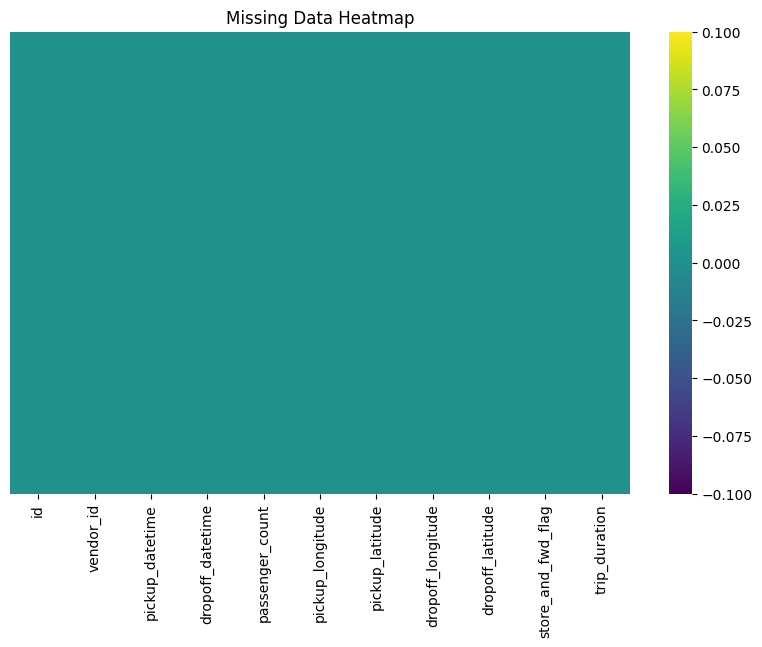

In [23]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

Our dataset isn't contain any null values, so we can proceed with our analysis.

## Preprocessing data

### Define the haversine distance function

In [26]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6378.137  # The earth's radius in kilometres
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

### Preprocessing function

In [27]:
def preprocessing(df: pd.DataFrame, scale=True, random_state=42) -> tuple:
    print("Starting preprocessing data...")
    
    # Processing time type data
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
    df['pickup_month'] = df['pickup_datetime'].dt.month

    
    # Geospatial feature engineering
    df['distance_km'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
    # Basic data cleaning and outlier removal
    df = df[
        (df['trip_duration'] > 60) & (df['trip_duration'] < 7200) &  # valid trip time
        (df['passenger_count'] > 0) &                                # at least 1 passenger
        (df['pickup_latitude'].between(40.5, 41.0)) &                # within NYC bounds
        (df['dropoff_latitude'].between(40.5, 41.0)) &
        (df['pickup_longitude'].between(-74.3, -73.6)) &
        (df['dropoff_longitude'].between(-74.3, -73.6))
    ]

    # Target transformation
    y = np.log1p(df['trip_duration'])  # log-transform to handle skewness

    # Drop unused columns
    X = df.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration'])

    # Encode categorical features
    X['store_and_fwd_flag'] = X['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

    # Split dataset into train, test, val sets with the ratio: ()
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

    # Feature scaling
    scaler = None
    if scale:
        numerical_cols = [
            'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude', 'pickup_hour',
            'pickup_dayofweek', 'pickup_month', 'distance_km'
        ]
        scaler = StandardScaler()
        X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
        X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
        X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    print("Preprocessing completed.")
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler